In [1]:
import numpy as np
import os
import re
from scipy.ndimage import filters

In [105]:
data = []
i = 0
while True:
    try:
        l = np.load('l{0}.npy'.format(i)).astype(np.float)
        gt = np.load('g{0}.npy'.format(i)).astype(np.float)
        costs = np.load('b{0}.npy'.format(i)).astype(np.float)
        acosts = np.load('a{0}.npy'.format(i)).astype(np.float)
        box_costs = (filters.uniform_filter(costs,[7,7,1],mode='nearest')*(7*7)).astype(np.int)
        
        #costs = np.clip(costs,0,costs.mean()-costs.std())
        #box_costs = np.clip(box_costs,0,box_costs.mean()-box_costs.std())

        best = np.argmin(box_costs,2)
    except:
        break
    max_disp = int(costs.shape[-1])
    image_width = costs.shape[1]
    image_height = costs.shape[0]
    data_size = costs.shape[0]*costs.shape[1]
    mask = np.ones_like(gt)
    mask[np.where(gt < 0)] = 0
    print gt.shape
    for y in xrange(image_height):
        for x in xrange(1,image_width):
            gp = gt[y,x-1]
            gn = gt[y,x]

            #if best[y,x] != int(round(gt[y,x])):
            #    continue
            #if gp == -2 or gp == -1 or gn == -2 or gn == -1:
            #    continue
            #if gp == -2 or gn == -2:
            #    continue
            ft = [gp,gn,gn - gp,round(gn)-round(gp)]

            for img in [l,costs,box_costs]:
                cp = img[y,x-1,:]
                cn = img[y,x,:]
                ft.append((cn - cp).mean())
            data.append(ft)
    for y in xrange(1,image_height):
        for x in xrange(image_width):
            gp = gt[y-1,x]
            gn = gt[y,x]
            
            #if best[y,x] != int(round(gt[y,x])):
            #    continue
            #if gp == -2 or gp == -1 or gn == -2 or gn == -1:
            #    continue
            #if gp == -2 or gn == -2:
            #    continue
            ft = [gp,gn,gn - gp,round(gn)-round(gp)]

            for img in [l,costs,box_costs]:
                cp = img[y-1,x,:]
                cn = img[y,x,:]
                ft.append(((cn - cp)).mean())
            data.append(ft)
    i = i + 1
    print len(data)
data = np.array(data)

(496L, 718L)
711042
(497L, 741L)
1446358
(481L, 707L)
2125304
(485L, 735L)
2837034
(476L, 699L)
3501307
(463L, 680L)
4129844
(486L, 720L)
4828478
(497L, 738L)
5560815
(375L, 450L)
5897490


In [108]:
print data.shape
import pandas as pd
data_f = pd.DataFrame(data,columns=['l','r','fp_gt','i_gt','rgbdiff','cmdiff','amdiff'])
data_f = data_f[((data_f.l != -2) & (data_f.r != -2) & (data_f.l != -1) & (data_f.r != -1))]
data_f['gt'] =  (((data_f.l != -2) & (data_f.r != -2) & (data_f.fp_gt.abs() > 1.5)) | ((data_f.l == -2) |(data_f.r == -2))).astype(np.int)
#data_f = data_f.drop(['l','r','fp_gt','i_gt','amdiff'],1)
#print data_f
#no_grad = np.array(data_f[data_f.gt < 1])
#grad = np.array(data_f[data_f.gt >0 ])
total = np.array(data_f[['gt','rgbdiff','cmdiff']])
edge = (data_f['gt'] == 1).sum()
nonedge = (data_f['gt'] == 0).sum()
print edge,nonedge,edge/float(nonedge)*100.0

(5897490L, 7L)
36391 4934083 0.73754332872


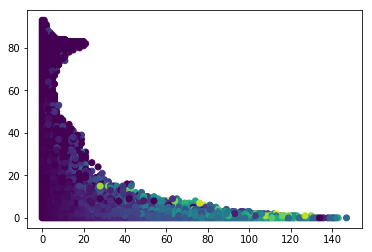

In [76]:
def hist2d(z,nbins=10):
    
    x = z[:,1]
    y = z[:,2]
    verification = z[:,0]
    print x.max(),x.min()
    print y.max(),y.min()
    print verification.max(),verification.min()
    _, xedges, yedges = np.histogram2d(x,y,bins=nbins)
    avgarr = np.zeros((nbins, nbins))
    H = np.zeros((nbins,nbins))
    # determine the X and Y bins each sample coordinate belongs to
    xbins = np.digitize(x, xedges[1:-1])
    ybins = np.digitize(y, yedges[1:-1])

    # calculate the bin sums (note, if you have very many samples, this is more
    # effective by using 'bincount', but it requires some index arithmetics
    for xb, yb, v in zip(xbins, ybins, verification):
        avgarr[yb, xb] += v
        H[yb,xb]+=1

    # replace 0s in H by NaNs (remove divide-by-zero complaints)
    # if you do not have any further use for H after plotting, the
    # copy operation is unnecessary, and this will the also take care
    # of the masking (NaNs are plotted transparent)
    divisor = H.copy()
    divisor[divisor==0.0] = np.nan

    # calculate the average
    avgarr /= divisor
    return avgarr,xedges,yedges,H

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline

plt.figure()
if False:
    plt.plot(abs(grad[gidx,0]),abs(grad[gidx,1]),ms=5,lw=0,marker='.')
    plt.plot(abs(no_grad[nidx,0]),abs(no_grad[nidx,1]),ms=5,lw=0,marker='.')

    plt.grid(True)
if False:
    plt.hexbin(abs(grad[:,0])+1,abs(grad[:,1])+1)
    plt.figure(figsize=(15,15))
    plt.hexbin(abs(no_grad[:,0])+1,abs(no_grad[:,1])+1)
if False:
    res,xbins,ybins,H = hist2d(abs(total),20)
    plt.imshow(res,origin='lower')
    plt.xlabel('color')
    plt.xticks(np.arange(20),np.unique(xbins))
    plt.yticks(np.arange(20),np.unique(ybins))
    plt.ylabel('sum disp diff')
    plt.colorbar()
    plt.figure()
    plt.imshow(res > 0.5,origin='lower')
    plt.figure()
    plt.imshow(H,origin='lower',norm=LogNorm())
    plt.colorbar()
if True:
    from collections import defaultdict
    cntr = defaultdict(float)
    prob = defaultdict(float)
    xscale = 1.0
    yscale = 1.0
    for z,x,y in abs(total):
        cntr[(int(x*xscale),int(y*yscale))] += z
        prob[(int(x*xscale),int(y*yscale))] += 1
    bad_keys = []
    for key in cntr:
        cntr[key] = cntr[key] / prob[key]
        if prob[key] < 15:
            bad_keys.append(key)
    for key in bad_keys:
        del cntr[key]
    x = []
    y = []
    c = []
    c2 = []
    for key in cntr:
        x.append(key[0])
        y.append(key[1])
        c.append(cntr[key])
        c2.append(prob[key])

    plt.scatter(x,y,c=c)



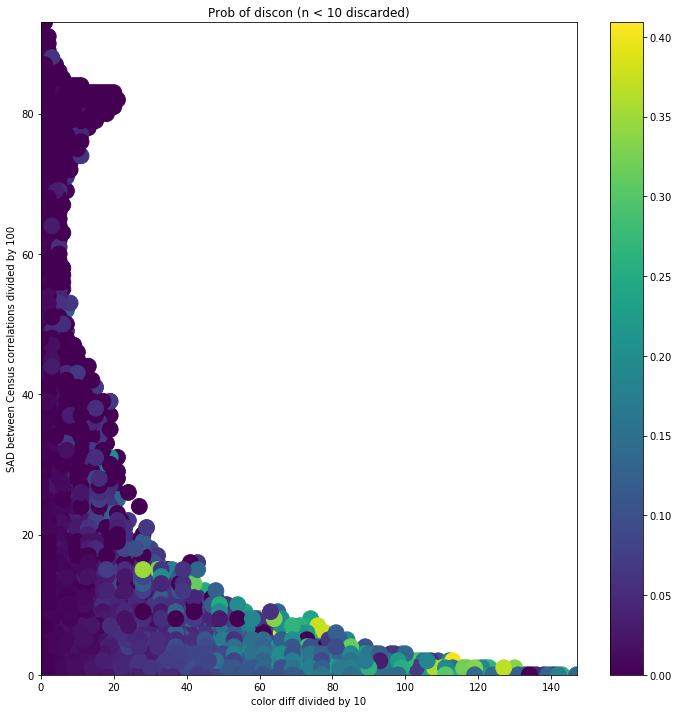

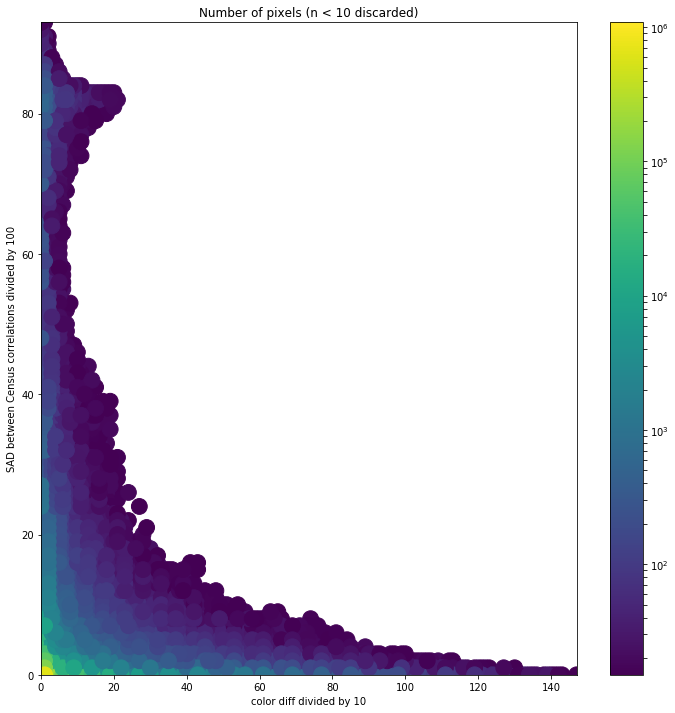

In [77]:
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=c,s=250)#, norm=LogNorm())
plt.title('Prob of discon (n < 10 discarded)')
plt.ylabel('SAD between Census correlations divided by 100')
plt.xlabel('color diff divided by 10')
plt.grid(False)
plt.xlim(0,max(x))
plt.ylim(0,max(y))
plt.colorbar()
plt.figure(figsize=(12,12))
plt.scatter(x,y,c=c2,s=250, norm=LogNorm())
plt.title('Number of pixels (n < 10 discarded)')
plt.ylabel('SAD between Census correlations divided by 100')
plt.xlabel('color diff divided by 10')
plt.grid(False)
plt.xlim(0,max(x))
plt.ylim(0,max(y))
plt.colorbar()

(4934083L, 3L) (36391L, 3L) (4970474L, 3L)


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


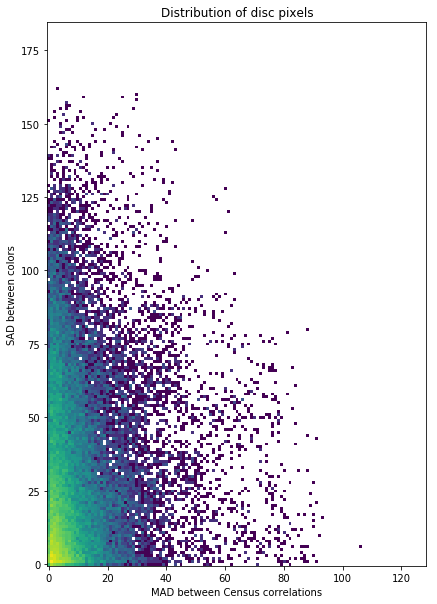

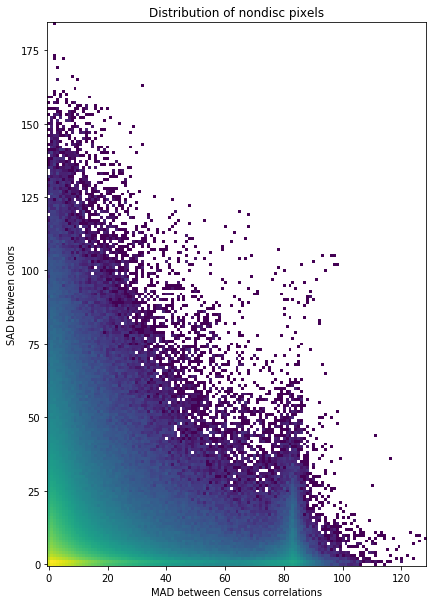

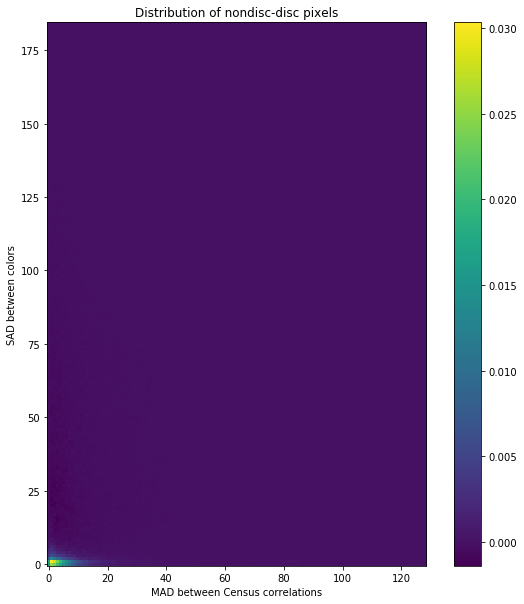

In [126]:
if False:
    plt.figure(figsize=(10,10))
    print total[total[:,0] == 0].shape,total[total[:,0] == 1].shape,total.shape
    nondisc = abs(np.round(total[total[:,0] == 0])[:,1:])
    disc = abs(np.round(total[total[:,0] == 1])[:,1:])
    disc_cnt = np.array(total[:,1].max(),total[:,1].max())
    plt.hexbin(disc[:,0],disc[:,1],norm=LogNorm())
    plt.xlim(0,total[:,1].max())
    plt.ylim(0,total[:,2].max())
    plt.title('Distribution of disc pixels')
    plt.ylabel('MAD between Census correlations')
    plt.xlabel('SAD between colors')
    
    plt.figure(figsize=(10,10))
    plt.hexbin(nondisc[:,0],nondisc[:,1],norm=LogNorm())
    plt.xlim(0,total[:,1].max())
    plt.ylim(0,total[:,2].max())
    plt.title('Distribution of nondisc pixels')
    plt.ylabel('MAD between Census correlations')
    plt.xlabel('SAD between colors')
else:
    plt.figure(figsize=(10,10))
    print total[total[:,0] == 0].shape,total[total[:,0] == 1].shape,total.shape
    nondisc = abs(np.round(total[total[:,0] == 0])[:,1:])
    disc = abs(np.round(total[total[:,0] == 1])[:,1:])
    disc_cnt = np.zeros(np.max(abs(np.round(total)),0)[1:] + 1)
    for x,y in disc:
        disc_cnt[x,y] += 1
    disc_cnt = disc_cnt/ disc_cnt.sum()
    plt.imshow(disc_cnt,origin='lower_left',norm=LogNorm())
    plt.title('Distribution of disc pixels')
    plt.xlabel('MAD between Census correlations')
    plt.ylabel('SAD between colors')
    
    plt.figure(figsize=(10,10))
    nondisc_cnt = np.zeros(np.max(abs(np.round(total)),0)[1:] + 1)
    for x,y in nondisc:
        nondisc_cnt[x,y] += 1
    nondisc_cnt = nondisc_cnt/ nondisc_cnt.sum()
    plt.imshow(nondisc_cnt,origin='lower_left',norm=LogNorm())
    plt.title('Distribution of nondisc pixels')
    plt.xlabel('MAD between Census correlations')
    plt.ylabel('SAD between colors')
    


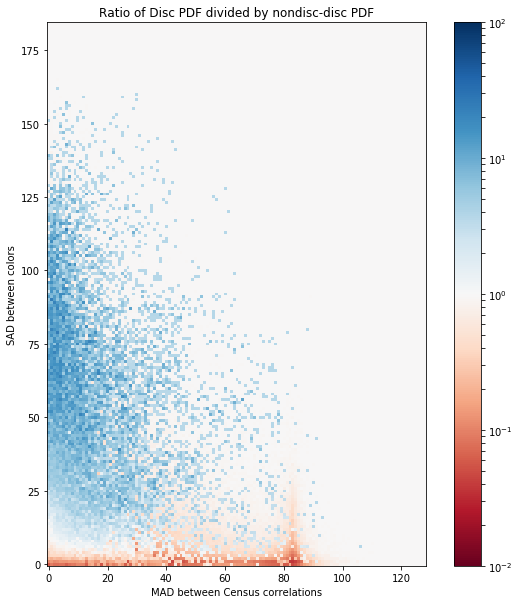

In [138]:
    plt.figure(figsize=(10,10))
    plt.imshow((disc_cnt+0.00001)/(nondisc_cnt+0.00001),origin='lower_left',norm=LogNorm(vmin=1e-2,vmax=1e2),cmap='RdBu')
    plt.title('Ratio of Disc PDF divided by nondisc-disc PDF')
    plt.xlabel('MAD between Census correlations')
    plt.ylabel('SAD between colors')
    plt.colorbar()

In [ ]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
abs_x = abs(total[:,1:])
abs_xy = (abs_x[:,0]*abs_x[:,1]).reshape([-1,1])
X = np.hstack([abs_x,abs_xy])
y = total[:,0].astype(np.int)
model = RandomForestClassifier(n_jobs=-1,max_depth=4)#SGDClassifier(n_jobs=-1,loss='hinge',penalty='l2',fit_intercept=True,class_weight='balanced')
model.fit(X,y)

In [ ]:
model.coef_,model.intercept_

In [ ]:
model.score(X,y)